In [1]:
import tensorflow as tf
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D,BatchNormalization
from tensorflow.keras.models import Model

In [2]:
# Đọc tệp Excel vào DataFrame
file_path = "/kaggle/input/btxrd-v3/classification.xlsx"  # Đường dẫn đến file Excel
df = pd.read_excel(file_path)

img_directory = '/kaggle/input/btxrd-v3/images' 
mask_directory = '/kaggle/input/btxrd-v3/masks'

In [3]:
# Hàm kiểm tra sự tồn tại của file mask
def check_mask_exists(image_id):
    mask_path = os.path.join(mask_directory, f"{os.path.splitext(image_id)[0]}.png")
    return os.path.exists(mask_path)

# Tạo cột mask_flag
df['mask_flag'] = df['image_id'].apply(lambda x: 1 if check_mask_exists(x) else 0)

In [4]:
# Lọc những ảnh có mask
df_with_mask = df[df['mask_flag'] == 1]

# Chia train, test, valid
df_train = df_with_mask[df_with_mask['tumor_category'] == 1].copy()
df_test  = df_with_mask[df_with_mask['tumor_category'] == 2].copy()
df_valid = df_with_mask[df_with_mask['tumor_category'] == 3].copy()

In [5]:
df_train['image_path'] = df_train['image_id'].apply(lambda x: os.path.join(img_directory, f"{os.path.splitext(x)[0]}.jpg"))
df_train['mask_path']  = df_train['image_id'].apply(lambda x: os.path.join(mask_directory, f"{os.path.splitext(x)[0]}.png"))

df_test['image_path'] = df_test['image_id'].apply(lambda x: os.path.join(img_directory, f"{os.path.splitext(x)[0]}.jpg"))
df_test['mask_path']  = df_test['image_id'].apply(lambda x: os.path.join(mask_directory, f"{os.path.splitext(x)[0]}.png"))

df_valid['image_path'] = df_valid['image_id'].apply(lambda x: os.path.join(img_directory,f"{os.path.splitext(x)[0]}.jpg"))
df_valid['mask_path']  = df_valid['image_id'].apply(lambda x: os.path.join(mask_directory, f"{os.path.splitext(x)[0]}.png"))

In [19]:
def load_image_and_mask(image_path, mask_path):
    # Đọc ảnh
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Đảm bảo ảnh có 3 kênh (RGB)
    image = tf.image.convert_image_dtype(image, tf.float32)

    # Đọc mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)  # Đảm bảo mask có 3 kênh (RGB)
    mask = tf.image.convert_image_dtype(mask, tf.float32)

    # Resize ảnh và mask để đảm bảo kích thước đồng nhất
    image = tf.image.resize(image, (224, 294))
    mask = tf.image.resize(mask, (224, 294))

    return image, mask

train_dataset = tf.data.Dataset.from_tensor_slices((df_train['image_path'], df_train['mask_path']))
train_dataset = train_dataset.map(load_image_and_mask)
train_dataset = train_dataset.batch(16).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((df_valid['image_path'], df_valid['mask_path']))
val_dataset = val_dataset.map(load_image_and_mask)
val_dataset = val_dataset.batch(16).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((df_test['image_path'], df_test['mask_path']))
test_dataset = test_dataset.map(load_image_and_mask)
test_dataset = test_dataset.batch(16).prefetch(tf.data.AUTOTUNE)

In [12]:
# Đọc ảnh
image = cv2.imread('/kaggle/input/btxrd-v3/masks/IMG000001.png')

# Kiểm tra số kênh
print(f"Số kênh của ảnh: {image.shape[2]}")

Số kênh của ảnh: 3


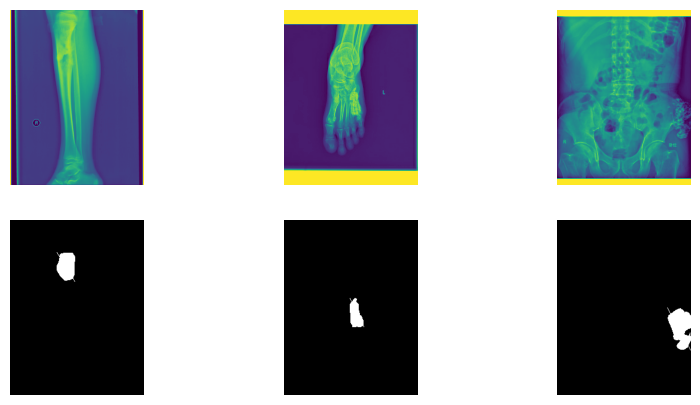

In [7]:
# Lấy một batch từ dataset
for image_batch, mask_batch in test_dataset.take(1):  
    plt.figure(figsize=(10, 5))
    
    for i in range(3):  # Hiển thị 3 ảnh đầu tiên
        plt.subplot(2, 3, i + 1)
        plt.imshow(image_batch[i].numpy())  # Hiển thị ảnh
        plt.axis("off")

        plt.subplot(2, 3, i + 4)
        plt.imshow(mask_batch[i].numpy().squeeze(), cmap="gray")  # Hiển thị mask
        plt.axis("off")

    plt.show()

In [22]:
def build_segnet(input_shape):
    inputs = Input(shape=input_shape)

    # Encoder (phần mã hóa)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder (phần giải mã)
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2), interpolation='bilinear')(x)  # UpSampling đúng

    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2), interpolation='bilinear')(x)  # UpSampling đúng

    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2), interpolation='bilinear')(x)  # UpSampling đúng

    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2), interpolation='bilinear')(x)  # UpSampling đúng

    # Output layer với 3 kênh (RGB) cho mask
    output = Conv2D(3, (3, 3), padding='same', activation='softmax')(x)  # 3 kênh

    model = Model(inputs, output)
    return model

# Khởi tạo mô hình SegNet với kích thước ảnh đầu vào là (224, 294, 3)
model = build_segnet((224, 294, 3))

# In summary của mô hình
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 294, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 224, 294, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_40               │ (None, 224, 294, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 112, 147, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 112, 147, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_41               │ (None, 112, 147, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 56, 74, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 56, 74, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_42               │ (None, 56, 74, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 28, 37, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 28, 37, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_43               │ (None, 28, 37, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 14, 19, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 14, 19, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_44               │ (None, 14, 19, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_20 (UpSampling2D)      │ (None, 28, 38, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_50 (Conv2D)                   │ (None, 28, 38, 256)         │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_45               │ (None, 28, 38, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 5,468,931 (20.86 MB)

 Trainable params: 5,465,091 (20.85 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [9]:
# Lấy danh sách các tệp ảnh và mask từ các thư mục
image_files = sorted([os.path.join(img_directory, f) for f in os.listdir(img_directory) if f.endswith('.jpg') or f.endswith('.jpeg')])
mask_files = sorted([os.path.join(mask_directory, f) for f in os.listdir(mask_directory) if f.endswith('.png')])

# Kích thước mong muốn (224, 294)
target_size = ( 294,224)

# Kiểm tra xem có ảnh hoặc mask nào có kích thước khác 224x294 không và resize lại
for image_path, mask_path in zip(image_files, mask_files):
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Kiểm tra nếu ảnh và mask có thể đọc được
    if image is None:
        print(f"Không thể đọc ảnh: {image_path}")
        continue
    if mask is None:
        print(f"Không thể đọc mask: {mask_path}")
        continue

    # Lấy kích thước hiện tại
    image_shape = image.shape
    mask_shape = mask.shape

    # In ra ảnh và mask có kích thước khác và resize chúng
    if image_shape[:2] != target_size:
        print(f"Ảnh có kích thước khác 224x294: {image_path} với kích thước {image_shape[:2]}")
        image = cv2.resize(image, target_size)
        cv2.imwrite(image_path, image)  # Lưu lại ảnh đã được resize

    if mask_shape != target_size:
        print(f"Mask có kích thước khác 224x294: {mask_path} với kích thước {mask_shape}")
        mask = cv2.resize(mask, target_size)
        cv2.imwrite(mask_path, mask)  # Lưu lại mask đã được resize

In [23]:
# Biên dịch mô hình với categorical_crossentropy
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Huấn luyện mô hình
history = model.fit(train_dataset, 
                    validation_data=val_dataset, 
                    epochs=10)

Epoch 1/10


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 224, 294, 3), output.shape=(None, 224, 304, 3)

In [ ]:
# Đánh giá mô hình trên tập kiểm tra
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()